In [1]:
import os
os.chdir("C:/Downloads")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models, fitting
from fitting_functions import *
import glob
from astropy.constants import c
from astropy.io import ascii
import astropy.units as u
from Borg_emission_lines import lines
import pickle
import random
import pprint
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import re
import ast

In [3]:
def clean_and_eval(s):
    s = str(s).strip("[]")
    s = re.sub(r'\s+', ',', s)
    s = re.sub(r',+', ',', s)
    s = s.strip(',')
    s = '[' + s + ']'
    try:
        return ast.literal_eval(s)
    except Exception:
        return [np.nan, np.nan]

In [4]:
file_spec = 'spectra_13Dec2024_full.p'
with open(file_spec, 'rb') as file:
    data_spec = pickle.load(file)


tab = ascii.read('highz_msaid_public.dat')
merged_df = pd.read_csv('Test_Dataframe.csv')

ratio_lines = ['[OIII]_5007_flux_SNR', 'Hbeta_flux_SNR', '[NeIII]_flux_SNR', '[OII]_doublet_flux_SNR']
borg_ids = ['2426_112','2426_1736','2426_1130','2426_1777','2426_169','2426_1690','2426_1655','1747_199','1747_732','1747_902','1747_1081','1747_817','1747_1425','1747_138']
proc_df = pd.read_csv('processed_test_df.csv')

In [5]:
borg_ids = ['2426_112','2426_1736','2426_1130','2426_1777','2426_169','2426_1690','2426_1655','1747_199','1747_732','1747_902','1747_1081','1747_817','1747_1425','1747_138']

In [6]:
def get_spec_key(gal):
    PREFERRED_KEYS = [
        'prism-clear',
        'g140h-f100lp',
        'g140m-f100lp',
        'g140m-f070lp',
        'g235h-f170lp',
        'g235m-f170lp',
        'g395h-f290lp',
        'g395m-f290lp'
    ]
    keys = data_spec[gal].keys()
    for k in PREFERRED_KEYS:
        if k in keys:
            return k
    return None  

## Spectral Fitting Function (SNR Calculation, Unit Conversion and Try-Except Statements added)

In [7]:
#This function mimics the provided Spectra Fitting code, but works on a particular set of galaxies individually, by Galaxy ID. Also allows for a custom SNR 

def find_spectral_features(gal_ids, num_bootstraps):
    all_snr_values = []
    # Collect Base SNR in the data set. 
    all_fit_results = []
    for idx, gal in enumerate(gal_ids):
        try:
            spec_key = get_spec_key(gal)
            if spec_key is None:
                print(f"Skipping {gal}: no supported instrument found")
                continue
            itab = np.where(tab['msaid'] == gal)[0]
            z = tab['z'][itab][0]
            wavelength = data_spec[gal][spec_key]['lam']*1e4
            flux_nu = data_spec[gal][spec_key]['flux']
            flux_nu_err = data_spec[gal][spec_key]['err']

            flux_l = convert_fnu_to_flambda(wavelength, flux_nu) * 1.e20
            flux_l_err = convert_fnu_to_flambda(wavelength, flux_nu_err) * 1.e20
            


            # select indices in wavelength array that correspond to our selected wavelength range
            redshift_lines = {key: value * (z + 1) for key, value in lines.items()}
            spectral_windows = {
                'CIV_window': [redshift_lines['CIV_doublet'] - 1500, redshift_lines['CIII]_doublet'] + 1500],
                'OII_window': [redshift_lines['[OII]_doublet'] - 1500, redshift_lines['Hgammma_OIII'] + 1500],
                'Hb_OIII_window': [redshift_lines['Hbeta'] - 1500, redshift_lines['[OIII]_5007'] + 1500]
            }

            # Begin bootstrap sampling:
            N = num_bootstraps
            bootstrap_results = {
                'continuum_slope': [],
                'continuum_intercept': [],
                'line_fluxes': [],  # List of dictionaries, one per iteration
                'flux_ratios': [],  # List of dictionaries, one per iteration
                'amplitudes': [],   # Add amplitudes to the dictionary
                'widths': []        # Add widths to the dictionary
            }   

            
            # **Compute Errors from Bootstrap Samples**
            final_results = {}  # Reset for each galaxy!
            count=0
            for _ in range(N):  # loop over the noise and then get the windows, and at every iteration compute the line fluxes and ratios
                count+=1
                # Generate new spectrum by adding Gaussian noise
                flux_new = flux_l + np.random.normal(0, flux_l_err)

                # Dictionary to store this iteration's line fluxes
                iteration_fluxes = {}
                iteration_ratios = {}
                iteration_amplitudes = {}
                iteration_widths = {}

                for window_name, window_range in spectral_windows.items():
                    sliced_index = np.where((wavelength >= window_range[0]) & (wavelength <= window_range[1]))
                    window_wavelength = wavelength[sliced_index]
                    window_flux = flux_l[sliced_index]
                    window_flux_err = flux_l_err[sliced_index]
                    invalid_spec = np.where((np.isfinite(window_flux) == False) | (np.isfinite(window_flux_err) == False))
                    window_flux[invalid_spec] = 0.
                    window_flux_err[invalid_spec] = 1.e20
            
                    model = models.Polynomial1D(1)
                    Nlines = 0

                    for key in redshift_lines:
                        lam = redshift_lines[key]
                        if (lam < np.nanmin(window_wavelength)) | (lam > np.nanmax(window_wavelength)):
                            continue

                        line = models.Gaussian1D(amplitude=np.nanmax(window_flux[(window_wavelength > (lam - 100.)) & (window_wavelength < (lam + 100.))]),
                                                mean=lam, stddev=60)
                        line.amplitude.min = 0.  # 1.e-3
                        line.amplitude.max = np.nanmax(window_flux[(window_wavelength > (lam - 100.)) & (window_wavelength < (lam + 100.))])
                        line.amplitude.fixed = False
                        line.stddev.min = 0.  # 1.e-3
                        line.stddev.fixed = False
                        model += line
                        Nlines += 1

                    # Fit model:
                    fit_g = fitting.LevMarLSQFitter(calc_uncertainties=True)
                    g = fit_g(model, window_wavelength, flux_new[sliced_index], weights=1 / window_flux_err)
                    # Check fit status using fit_info
                    status = fit_g.fit_info.get('status')

                
                    # Store bootstrapped parameters for this iteration
                    bootstrap_results['continuum_slope'].append(g.parameters[0])  # Use g.parameters[0] for the slope (c0)
                    bootstrap_results['continuum_intercept'].append(g.parameters[1])  # Use g.parameters[1] for the intercept (c1)


                    #for line_name, lam in redshift_lines.items():
                    for i, line_name in enumerate([key for key in redshift_lines if redshift_lines[key] >= np.nanmin(window_wavelength) and redshift_lines[key] <= np.nanmax(window_wavelength)]):

                        #print(line_name)
                        amp = getattr(g, f'amplitude_{i+1}').value
                        width = getattr(g, f'stddev_{i+1}').value

                        # Store in dictionaries for later error calculation
                        if line_name not in iteration_amplitudes:
                            iteration_amplitudes[line_name] = []
                            iteration_widths[line_name] = []

                        iteration_amplitudes[line_name].append(amp)
                        iteration_widths[line_name].append(width)

                        # **Compute line flux**
                        flux = amp * width * np.sqrt(2 * np.pi) * 1.e-2
                        iteration_fluxes[f"{line_name}_flux"] = flux
                    # print(count) #correctly goes throush the 3 spectral windows and finds fluxes for all lines, this for 100 times


                # **Compute flux ratios**
                # print(iteration_fluxes) #Fluxes saved correctly! No overwritting
                if '[NeIII]_flux' in iteration_fluxes and '[OII]_doublet_flux' in iteration_fluxes:
                    iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']

                if '[OIII]_5007_flux' in iteration_fluxes and 'Hbeta_flux' in iteration_fluxes:
                    iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']

                if 'Hdelta_flux' in iteration_fluxes and 'Hbeta_flux' in iteration_fluxes:
                    iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']

                if 'Hgammma_OIII_flux' in iteration_fluxes and 'Hbeta_flux' in iteration_fluxes:
                    iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']



                # Debugging: Print ratios for each iteration
                #print(f"Iteration {count} flux ratios: {iteration_ratios}") This worked!

                # Store this bootstrap iteration's results
                bootstrap_results['line_fluxes'].append(iteration_fluxes)
                bootstrap_results['flux_ratios'].append(iteration_ratios)
                bootstrap_results['amplitudes'].append(iteration_amplitudes)
                bootstrap_results['widths'].append(iteration_widths)

            # Now that all bootstrap iterations are done, plot and save the fit for each spectral window
            for window_name, window_range in spectral_windows.items():
                sliced_index = np.where((wavelength >= window_range[0]) & (wavelength <= window_range[1]))
                window_wavelength = wavelength[sliced_index]
                window_flux = flux_l[sliced_index]
                window_flux_err = flux_l_err[sliced_index]

                # Define the model and fit it
                model = models.Polynomial1D(1)
                Nlines = 0

                for key in redshift_lines:
                    lam = redshift_lines[key]
                    if (lam < np.nanmin(window_wavelength)) | (lam > np.nanmax(window_wavelength)):
                        continue

                    line = models.Gaussian1D(
                        amplitude=np.nanmax(window_flux[(window_wavelength > (lam - 100.)) & (window_wavelength < (lam + 100.))]),
                        mean=lam, stddev=60
                    )
                    line.amplitude.min = 0.
                    line.amplitude.max = np.nanmax(window_flux[(window_wavelength > (lam - 100.)) & (window_wavelength < (lam + 100.))])
                    model += line
                    Nlines += 1

                # Fit the model to the spectrum
                fit_g = fitting.LevMarLSQFitter(calc_uncertainties=True)
                g = fit_g(model, window_wavelength, window_flux, weights=1 / window_flux_err, maxiter=10000, estimate_jacobian=True)

                #############################################################################################################
                #Add Fit Diagnostics (Metric to see which galaxies fit poorly) 
                #Compute RMSE of residual, coming from subtracting observed flux in specific wavelength from the
                #fit function to the data in that same wavelength window 
                residuals = window_flux - g(window_wavelength)
                
                rms = np.sqrt(np.mean(residuals**2)) 
                print(f"RMS for {gal} in {window_name}: {rms:.4g}")
                final_results[f"{window_name}_fit_rms"] = rms
                
                
                #############################################################################################################
                # Plot and save the fit for each spectral window
                fig = plt.figure(figsize=(7, 7))
                plt.title(gal + " - " + window_name, fontsize=16)
                plt.step(window_wavelength, window_flux, where='mid', color='k', label='Data')  # Original data
                plt.step(window_wavelength, window_flux_err, where='mid', color='grey', linestyle='dotted', label='Error')  # Error bars
                residuals = window_flux - g(window_wavelength)  # Residuals
                plt.step(window_wavelength, residuals, where='mid', color='orange', label='Residuals')  # Residuals
                plt.plot(window_wavelength, g(window_wavelength), color='red', label='Fit')  # Model fit

                plt.xlabel(r"Wavelength ($\AA$)", fontsize=18)
                plt.ylabel(r"Flux (erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$)", fontsize=18)
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)

                # Save the plot as a PNG (or any other format)
                plot_filename = f"Figures_spectra/fit_{gal}_{window_name}.png"
                plt.savefig(plot_filename)  # Save the figure with a unique filename based on the window name

                plt.close()  # Close the plot after saving

            # **Find all emission lines across bootstraps**
            all_detected_lines = set()
            for iteration in bootstrap_results['line_fluxes']:
                all_detected_lines.update(iteration.keys())  # Collect all line_flux keys

            # **Compute errors for all detected lines**
            for line in all_detected_lines:
                flux_values = [iteration[line] for iteration in bootstrap_results['line_fluxes'] if line in iteration]
                if len(flux_values) > 0:  # Ensure at least one detection
                    flux_16, flux_median, flux_84 = np.percentile(flux_values, [16, 50, 84])
                    final_results[line] = flux_median
                    final_results[f"{line}_err"] = np.array([flux_median - flux_16, flux_84 - flux_median])  # Asymmetric errors
                    err_minus = flux_median - flux_16
                    err_plus = flux_84 - flux_median 
                    avg_error = (err_minus + err_plus) / 2 #Gives STD. 
                    line_SNR = flux_median / avg_error if avg_error > 0 else 0 #Avoid divisions by 0
                    final_results[f"{line}_SNR"] = line_SNR #Store SNR Values
                    
            #SNR Checking       
        
            # **Compute errors for flux ratios**
            for ratio in ['NeIII_OII_ratio', 'OIII5007_Hbeta_ratio','Hdelta_Hbeta_ratio','Hgamma_Hbeta_ratio']:
                ratio_values = [iteration[ratio] for iteration in bootstrap_results['flux_ratios'] if ratio in iteration]
                if len(ratio_values) > 0:
                    ratio_16, ratio_median, ratio_84 = np.percentile(ratio_values, [16, 50, 84])
                    final_results[ratio] = ratio_median
                    final_results[f"{ratio}_err"] = np.array([ratio_median - ratio_16, ratio_84 - ratio_median])                      

            # Append results **per galaxy**
            all_fit_results.append({gal: final_results})
            print(f"Final results for {gal}:", final_results.keys())
        except Exception as e: 
            print(f"Failed on {gal} due to: {e}")
    print(f"Processed {len(all_fit_results)} galaxies")
    return(all_fit_results)
                                   
    
                          
                          


## BPT Making Functions

In [8]:
bin_path = 'Users/isaia/OneDrive/Documents/UCLA/UCLA REU 2025/Data/Test Data Bins/'

In [9]:
def get_df(survey,num_bootstraps, z_min, z_max):
    survey_df = proc_df[proc_df['survey'] == survey]
    survey_ids =  list(survey_df[(survey_df['z'] > z_min) & (survey_df['z'] < z_max)]['Galaxy ID'])
    results = find_spectral_features(survey_ids, num_bootstraps)
    with open('test_data_fit_results_ratios.pkl', 'wb') as f:
        pickle.dump(results, f)
    with open('test_data_fit_results_ratios.pkl', 'rb') as f:
        survey_results = pickle.load(f)
    keys_set = set()
    for galaxy in survey_results:
        gal_id, result_dict = list(galaxy.items())[0]
        keys_set.update(result_dict.keys())

    all_keys = sorted(list(keys_set))
    dictionary = {key: [] for key in all_keys}
    gal_ids = []

    for galaxy in survey_results: 
        gal_id, result_dict = list(galaxy.items())[0]
        gal_ids.append(gal_id)  # Keep Galaxy ID
        for key in all_keys:
            dictionary[key].append(result_dict.get(key, np.nan))

    #Add the galaxy ids 
    survey_df = pd.DataFrame(dictionary)
    survey_df.insert(0, 'Galaxy ID', gal_ids)

    #Ensure the correct bin directory exists
    bin_dir = os.path.join(bin_path, survey)
    os.makedirs(bin_dir, exist_ok = True)
    
    filename = f"{survey}_z_{z_min}_to_{z_max}.pkl"
    full_path = os.path.join(bin_dir, filename)
    with open (full_path, 'wb') as f: 
        pickle.dump(survey_df, f)
    
    print(f"Saved DataFrame to: {full_path}")
    return survey_df
          



In [10]:
def filter_galaxy(bin_df, SNR_filter, line_ratios): 
    # Ensure input is a list even if single string is passed
    if isinstance(line_ratios, str):
        line_ratios = [line_ratios]
    
    # Build a combined mask that requires all line ratios to pass the SNR filter
    mask = np.ones(len(bin_df), dtype=bool)
    for ratio in line_ratios:
        if ratio in bin_df.columns:
            mask &= bin_df[ratio] > SNR_filter
        else:
            print(f"Warning: {ratio} not found in DataFrame columns.")

    # Apply mask to filter
    filtered_df = bin_df[mask]
    return filtered_df

### Modified BPT Function (Custom X,Y Limits)

In [11]:
def custom_make_bpt(bin_df, ratio_x, err_x, ratio_y, err_y,
             x_label=None, y_label=None,
             title=None, xscale='linear', yscale='linear',
             xlim=None, ylim=None,                # ← defaults to None for autoscaling
             log_transform=True,
             verbose=True, ax=None, color='green', 
             pickle_filename=None, save_pickle=False, plot_filename=None):
    # Clean error columns
    bin_df[err_x] = bin_df[err_x].apply(clean_and_eval)
    bin_df[err_y] = bin_df[err_y].apply(clean_and_eval)

    # Drop invalid rows
    initial_count = len(bin_df)
    valid_data = bin_df.dropna(subset=[ratio_x, ratio_y])
    valid_data = valid_data[
        valid_data[err_x].apply(lambda x: isinstance(x, list) and len(x) == 2 and not any(np.isnan(x))) & 
        valid_data[err_y].apply(lambda x: isinstance(x, list) and len(x) == 2 and not any(np.isnan(x)))
    ]
    dropped_count = initial_count - len(valid_data)
    if verbose and dropped_count > 0:
        print(f"Dropped {dropped_count} galaxies due to invalid ratios or errors.")

    if len(valid_data) == 0:
        print("No galaxies to plot after filtering.")
        return
    
    x_raw = valid_data[ratio_x].to_numpy()
    y_raw = valid_data[ratio_y].to_numpy()
    xerr_array = np.vstack(valid_data[err_x].tolist()).astype(float)
    yerr_array = np.vstack(valid_data[err_y].tolist()).astype(float)
    labels = valid_data['Galaxy ID'].to_numpy()

    # Log transform if needed
    if log_transform:
        with np.errstate(divide='ignore', invalid='ignore'):
            x = np.log10(x_raw)
            y = np.log10(y_raw)
        x_label = f"{ratio_x}_log"
        y_label = f"{ratio_y}_log"
        title = f"{x_label} vs {y_label}"
        log_mask = np.isfinite(x) & np.isfinite(y)
        x = x[log_mask]
        y = y[log_mask]
        xerr_array = 0.434 * np.abs(xerr_array[log_mask] / x_raw[log_mask, np.newaxis])
        yerr_array = 0.434 * np.abs(yerr_array[log_mask] / y_raw[log_mask, np.newaxis])
        labels = labels[log_mask]
    else:
        x = x_raw
        y = y_raw
        if len(x) == 0 or len(y) == 0:
            print("All values removed after log filtering.")
            return
    # Plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 7))
    else:
        fig = ax.figure

    ax.errorbar(x, y, xerr=xerr_array.T, yerr=yerr_array.T,
                fmt='o', color=color, alpha=0.7)

    # Annotate points
    for xi, yi, label in zip(x, y, labels):
        ax.annotate(label, (xi, yi), fontsize=8, alpha=0.8)

    # Axis labels and styles
    ax.set_xlabel(x_label if x_label else ratio_x, fontsize=14)
    ax.set_ylabel(y_label if y_label else ratio_y, fontsize=14)
    ax.set_title(title if title else f"{ratio_x} vs {ratio_y}", fontsize=15)
    ax.grid(True)
    sns.set_theme(style="ticks")
    fig.tight_layout()

    # Axis scales
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)

    # Axis limits — only set if provided
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    print(f"Plotted {len(labels)} galaxies")

    # Automatically save the plot as PNG if plot_filename is provided
    if plot_filename:
        fig.savefig(plot_filename)
        print(f"Figure saved as PNG to {plot_filename}")

    # Automatically save to pickle if needed
    if pickle_filename and save_pickle:
        with open(pickle_filename, 'wb') as f:
            pickle.dump(fig, f)
        if verbose:
            print(f"Figure saved as pickle to {pickle_filename}")

    return fig, ax

    

# Automated Process for all Galaxies 

# Process all bins together (Both Batches)

In [12]:
survey_bins = {
    'rubies':      [(4.5, 5.5), (5.5, 6.5), (6.5, 7.5), (7.5, 8.5), (8.5, 9.5)],
    'jades':       [(4.5, 5.5), (5.5, 6.5), (6.5, 7.5), (7.5, 8.5), (8.5, 9.5), (9.5, 10.5), (10.5, 11.5)],
    'canucs':      [(4.5, 5.5), (5.5, 6.5), (6.5, 7.5), (7.5, 8.5), (8.5, 9.5), (9.5, 10.5)],
    'castellano':  [(4.5, 5.5), (5.5, 6.5), (6.5, 7.5), (7.5, 8.5), (8.5, 9.5), (9.5, 10.5), (10.5, 11.5), (11.5, 12.5)],
    'eisenstein':  [(4.5, 5.5), (5.5, 6.5), (6.5, 7.5), (7.5, 8.5), (8.5, 9.5), (9.5, 10.5), (10.5, 11.5), (11.5, 12.5), (12.5, 13.5)],
    'arrabal':     [(4.5, 5.5), (5.5, 6.5), (6.5, 7.5), (7.5, 8.5), (8.5, 9.5), (9.5, 10.5), (10.5, 11.5)],
    'coe':         [(4.5, 5.5), (5.5, 6.5), (6.5, 7.5), (7.5, 8.5), (8.5, 9.5), (9.5, 10.5)],
    'chen':        [(4.5, 5.5), (5.5, 6.5), (6.5, 7.5), (7.5, 8.5), (8.5, 9.5), (9.5, 10.5)],
    'stark':       [(4.5, 5.5), (5.5, 6.5), (6.5, 7.5), (7.5, 8.5)],  # From both bins, same
    'kelly':       [(4.5, 5.5), (5.5, 6.5), (6.5, 7.5), (7.5, 8.5), (8.5, 9.52)],
    'glazebrook':  [(4.5, 5.5), (5.5, 6.5), (6.5, 7.5)],
    'smacs':       [(4.5, 5.5), (5.5, 6.5), (6.5, 7.5), (7.5, 8.5)],  # From both bins, same
    'ceers':       [(4.5, 5.5), (5.5, 6.5), (6.5, 7.5), (7.5, 8.5), (8.5, 9.5), (9.5, 10.5), (10.5, 11.5)],
    'uncover':     [(4.5, 5.5), (5.5, 6.5), (6.5, 7.5), (7.5, 8.5), (8.5, 9.5), (9.5, 10.5), (10.5, 11.5), (11.5, 12.5), (12.5, 13.5)],
    'borg':        [(5.5, 6.5), (6.5, 7.5), (7.5, 8.5)],
    'borg_fs':     [(6.5, 7.5), (7.5, 8.5)],
}


In [13]:
filtered_proc_df = proc_df[proc_df['survey'].isin(list(survey_bins.keys()))]


filtered_proc_df['survey'].unique()

array(['jades', 'canucs', 'ceers', 'coe', 'borg', 'borg_fs', 'stark',
       'uncover', 'glazebrook', 'smacs', 'arrabal', 'chen', 'kelly',
       'castellano', 'eisenstein', 'rubies'], dtype=object)

In [15]:
# Optimized redshift bins for each survey (edit as needed for your science goals)
bpt_base_path = "bpt_plots"
os.makedirs(bpt_base_path, exist_ok=True)


# Line ratios for filtering and plotting
line_ratios_for_filter = ['NeIII_OII_SNR', 'OIII5007_Hbeta_SNR']
ratio_x = 'NeIII_OII_ratio'
err_x = 'NeIII_OII_ratio_err'
ratio_y = 'OIII5007_Hbeta_ratio'
err_y = 'OIII5007_Hbeta_ratio_err'

# Get unique surveys from your dataset
all_surveys = filtered_proc_df['survey'].unique()

for survey in all_surveys:
    survey_lower = survey.lower()
    bins = survey_bins.get(survey_lower)
    if bins is not None:
        for zmin, zmax in bins:
            # 1️⃣ Extract dataframe for this survey and redshift bin
            df_subset = get_df(survey, 100, zmin, zmax)

            # 2️⃣ Filter for SNR > 2 for both ratios
            df_snr = filter_galaxy(df_subset, SNR_filter=2, line_ratios=line_ratios_for_filter)

            # 3️⃣ Generate BPT diagram if df_snr is not empty
            if not df_snr.empty:

                survey_plot_dir = os.path.join(bpt_base_path, survey)
                os.makedirs(survey_plot_dir, exist_ok = True)

                pickle_path = os.path.join(survey_plot_dir, f"{survey}_z_{zmin}_to_{zmax}.pkl")
                plot_filename = f"{survey}_z_{zmin}_to_{zmax}.png"
                plot_path = os.path.join(survey_plot_dir, plot_filename)
                fig = custom_make_bpt(
                    df_snr,
                    ratio_x=ratio_x,
                    err_x=err_x,
                    ratio_y=ratio_y,
                    err_y=err_y,
                    title=f"{survey} z={zmin}-{zmax}",
                    x_label=r"[NeIII]/[OII]",
                    y_label=r"[OIII]/Hβ",
                    save_pickle = True, pickle_filename = pickle_path, plot_filename = plot_path
                )

            else:
                print(f"No galaxies passed SNR filter in {survey} z={zmin}-{zmax}.")
    else:
        print(f"⚠️ No redshift bins defined for survey '{survey}' — skipping.")

KeyboardInterrupt: 

# Borg Test again RQ

In [ ]:
borg_survs = ['borg', 'borg_fs']
filtered_borg_survs = filtered_proc_df[filtered_proc_df['survey'].isin(borg_survs)]

In [ ]:
mask = (filtered_borg_survs['z'] > 7.5) & (filtered_borg_survs['z'] < 8.5)

borg_7 = filtered_borg_survs[mask]

borg_7

,survey,field,prog_id,id,Galaxy ID,ra,dec,z,flag_lya,flag_agn,...,NeIII_OII_ratio_err,OIII5007_Hbeta_ratio,OIII5007_Hbeta_ratio_err,Hdelta_Hbeta_ratio,Hdelta_Hbeta_ratio_err,Hgamma_Hbeta_ratio,Hgamma_Hbeta_ratio_err,MgI_5174_flux,MgI_5174_flux_err,MgI_5174_flux_SNR
651,borg,22031851,1747,1081,1747_1081,330.692840,18.858110,7.838,0,0,...,[0.14315444 0.23160126],3.309844,[0.78661743 1.06203097],0.271076,[0.22597208 0.45361748],0.789971,[0.45113499 0.37024613],NaN,NaN,NaN
655,borg,14375044,1747,1425,1747_1425,219.210540,50.725990,7.553,0,0,...,[0.51829623 0.72117207],7.025122,[0.94683788 1.50743381],0.257304,[0.08764306 0.10263947],0.353672,[0.10126577 0.29899893],0.0,[0. 0.],0.0
656,borg,10335051,1747,199,1747_199,158.186520,50.841590,8.316,0,0,...,[0.06987933 0.08470453],4.778924,[0.45252744 0.62169389],0.114160,[0.11415981 0.06223643],0.227704,[0.05779177 0.1506445 ],NaN,NaN,NaN
661,borg,04405244,1747,732,1747_732,69.946170,-52.731810,8.226,-99,-99,...,[0.20456963 1.14466687],7.512071,[1.75259453 1.77373368],0.265428,[0.26542791 0.17588767],0.637464,[0.25985983 0.40577595],NaN,NaN,NaN
662,borg,04095317,1747,817,1747_817,62.337140,-53.258990,7.556,-99,-99,...,[0.06681636 0.12797405],6.605040,[0.31418897 0.34918674],0.157271,[0.0309146 0.09305432],0.642273,[0.16397699 0.08452804],NaN,NaN,NaN
663,borg,09554528,1747,902,1747_902,148.828080,45.489530,7.905,-99,-99,...,[0.1647922 0.24436453],6.251010,[0.60177875 0.60859822],0.170023,[0.08008168 0.05161481],0.358121,[0.26174439 0.07849357],NaN,NaN,NaN
666,borg_fs,09562847,2426,1130,2426_1130,149.122770,28.792000,8.490,-99,-99,...,[nan nan],4.746030,[1.22473981 6.32838826],0.392407,[0.39240729 1.19573926],1.096111,[0.64416473 1.28543828],NaN,NaN,NaN
667,borg_fs,09535153,2426,1655,2426_1655,148.294710,51.877090,8.030,-99,-99,...,[0.2466449 0.5551963],4.260053,[0.41099858 0.53988082],0.202602,[0.05422781 0.19187442],0.474240,[0.2935166 0.23235889],NaN,NaN,NaN
668,borg_fs,09562847,2426,169,2426_169,149.113240,28.812230,8.230,-99,-99,...,[0.82804245 0.73784696],5.342047,[0.26124396 0.24406685],0.189945,[0.06787201 0.0384386 ],0.602728,[0.10405309 0.10762054],NaN,NaN,NaN
669,borg_fs,09562847,2426,1690,2426_1690,149.113390,28.812240,8.205,-99,-99,...,[0. 0.34623896],5.398879,[2.18170909 4.49612245],0.000000,[0. 0.31617759],0.319934,[0.22672152 0.37766559],NaN,NaN,NaN


Dropped 1 galaxies due to invalid ratios or errors.
Plotted 10 galaxies


C:\Users\isaia\AppData\Local\Temp\ipykernel_23628\4089191204.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin_df[err_x] = bin_df[err_x].apply(clean_and_eval)
C:\Users\isaia\AppData\Local\Temp\ipykernel_23628\4089191204.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bin_df[err_y] = bin_df[err_y].apply(clean_and_eval)


(<Figure size 800x700 with 1 Axes>,
 <Axes: title={'center': 'NeIII_OII_ratio_log vs OIII5007_Hbeta_ratio_log'}, xlabel='NeIII_OII_ratio_log', ylabel='OIII5007_Hbeta_ratio_log'>)

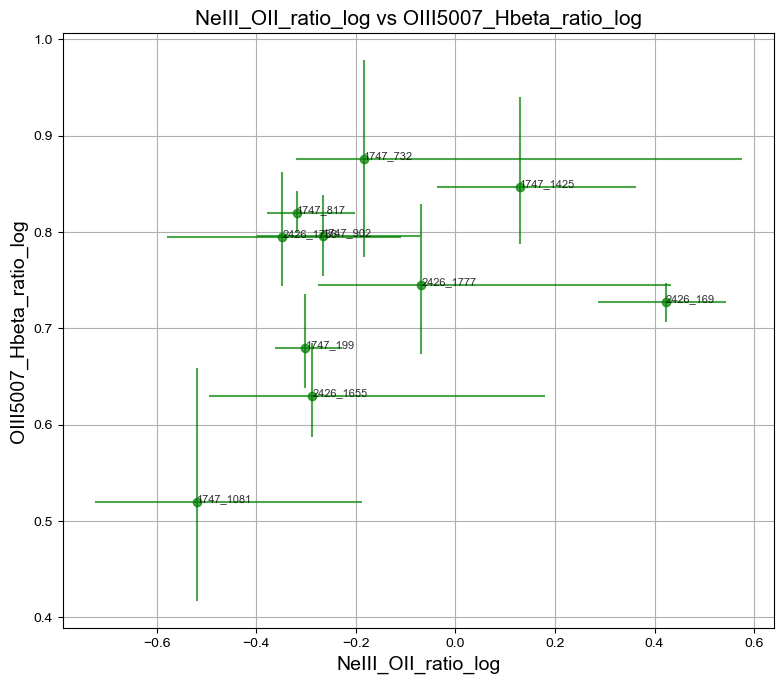

In [ ]:
custom_make_bpt(borg_7,
    ratio_x='NeIII_OII_ratio',
    err_x='NeIII_OII_ratio_err',
    ratio_y='OIII5007_Hbeta_ratio',
    err_y='OIII5007_Hbeta_ratio_err',
    log_transform=True, xscale='linear', yscale='linear')

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_13260\4260734735.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 1747_1084 in CIV_window: 0.3642
RMS for 1747_1084 in OII_window: 0.1231
RMS for 1747_1084 in Hb_OIII_window: 0.09897
Final results for 1747_1084: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_fl

C:\Users\isaia\AppData\Local\Temp\ipykernel_13260\4260734735.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_13260\4260734735.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_13260\4260734735.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_13260\4260734735.py:130: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\

RMS for 1747_1257 in CIV_window: 0.5153
RMS for 1747_1257 in OII_window: 0.1187
RMS for 1747_1257 in Hb_OIII_window: 0.0997
Final results for 1747_1257: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flu

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


RMS for 1747_412 in CIV_window: 0.4566
RMS for 1747_412 in OII_window: 0.1191
RMS for 1747_412 in Hb_OIII_window: 0.08596
Final results for 1747_412: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_S

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)


RMS for 1747_138 in CIV_window: 0.3082
RMS for 1747_138 in OII_window: 0.1071
RMS for 1747_138 in Hb_OIII_window: 0.1447
Final results for 1747_138: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SN

C:\Users\isaia\AppData\Local\Temp\ipykernel_13260\4260734735.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_13260\4260734735.py:127: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_13260\4260734735.py:130: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_13260\4260734735.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipyker

RMS for 1747_587 in CIV_window: 0.3764
RMS for 1747_587 in OII_window: 0.1138
RMS for 1747_587 in Hb_OIII_window: 0.1417
Final results for 1747_587: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SN

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


RMS for 1747_m5 in CIV_window: 0.5243
RMS for 1747_m5 in OII_window: 0.2666
RMS for 1747_m5 in Hb_OIII_window: 0.5036
Final results for 1747_m5: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_13260\4260734735.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_13260\4260734735.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_13260\4260734735.py:130: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 1747_1081 in CIV_window: 0.2823
RMS for 1747_1081 in OII_window: 0.1496
RMS for 1747_1081 in Hb_OIII_window: 0.1461
Final results for 1747_1081: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'OIII5007

C:\Users\isaia\AppData\Local\Temp\ipykernel_13260\4260734735.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 1747_732 in CIV_window: 0.2485
RMS for 1747_732 in OII_window: 0.106
RMS for 1747_732 in Hb_OIII_window: 0.1919
Final results for 1747_732: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'OIII5007_Hbet

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)


RMS for 2426_112 in CIV_window: 0.4326
RMS for 2426_112 in OII_window: 0.1854
RMS for 2426_112 in Hb_OIII_window: 0.1606
Final results for 2426_112: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SN

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_13260\4260734735.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_13260\4260734735.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_13260\4260734735.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_13260\4260734735.py:127:

RMS for 2426_1130 in CIV_window: 0.3944
RMS for 2426_1130 in OII_window: 0.2191
RMS for 2426_1130 in Hb_OIII_window: 0.2504


c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Final results for 2426_1130: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'OIII5007_Hbeta_ratio', 'OIII5007_Hbeta_ratio_err', 'Hdelta_Hbeta_ratio', 'Hdelta_Hbeta_ratio_err', 'Hgamma_Hbeta_ratio', 'Hgamma_Hbe

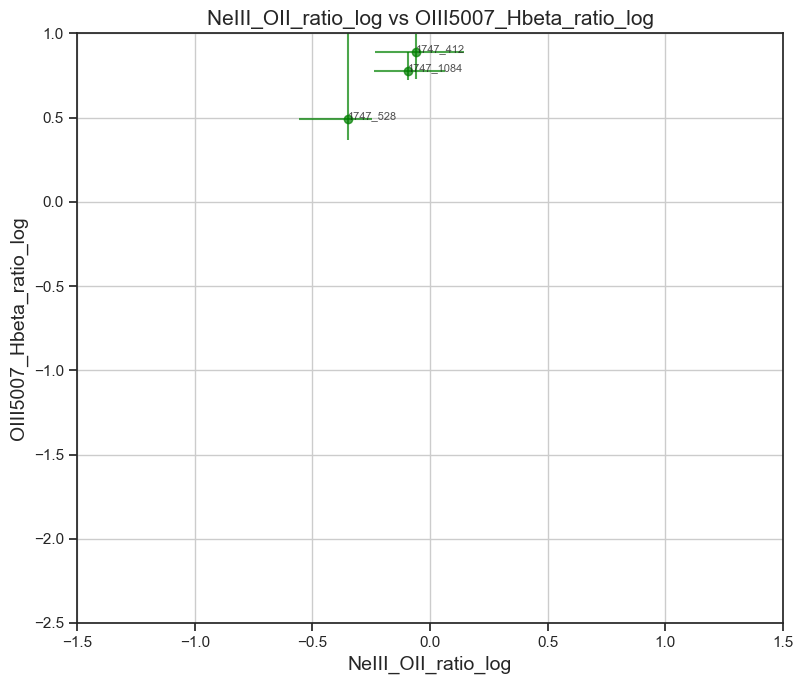

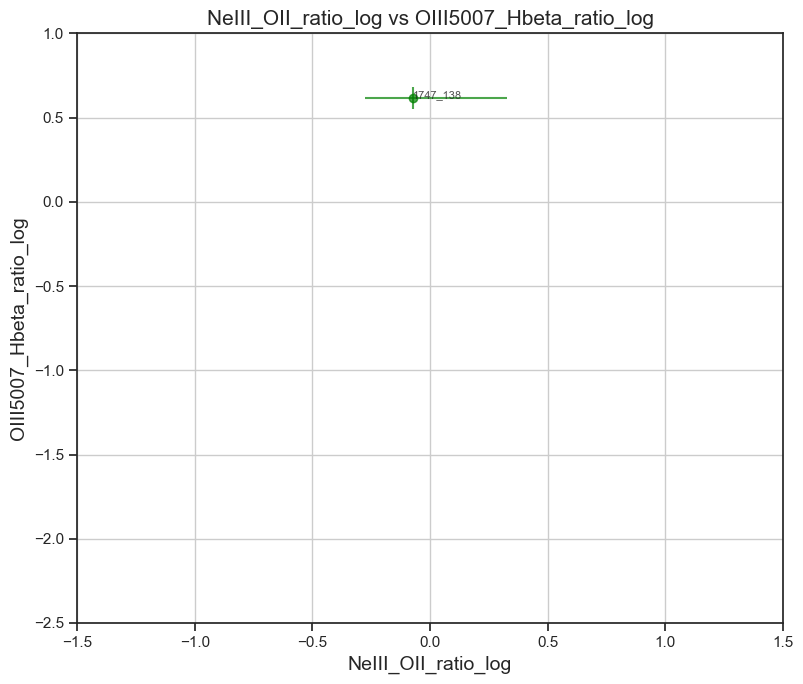

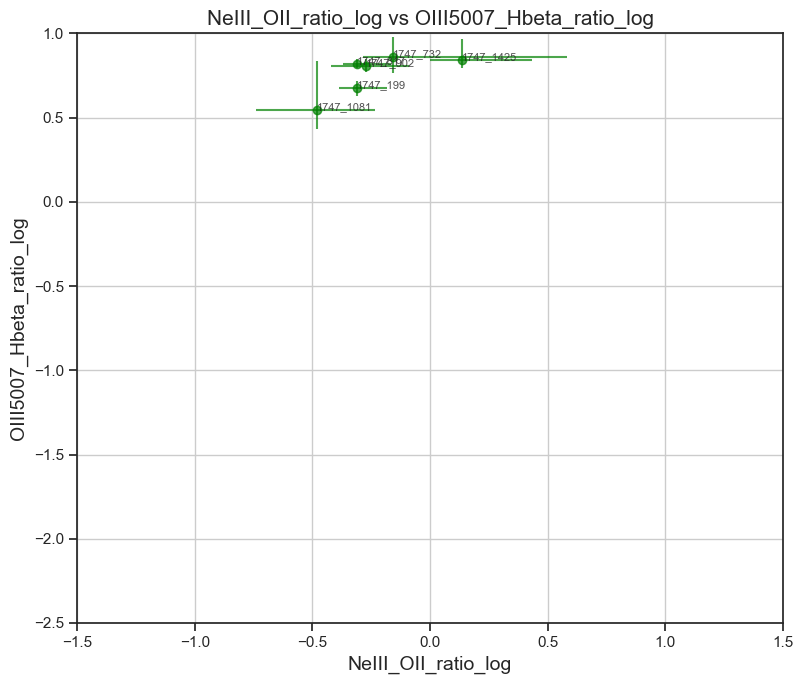

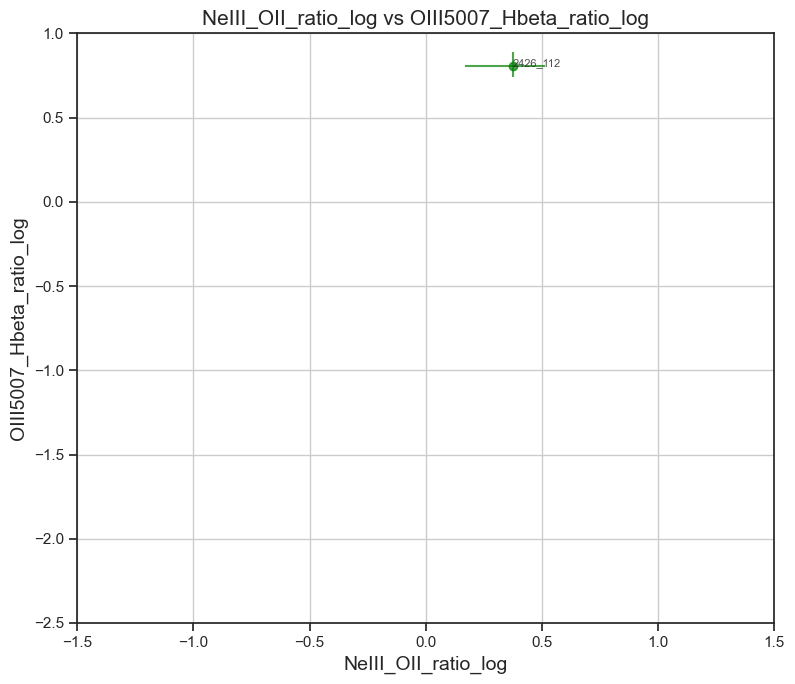

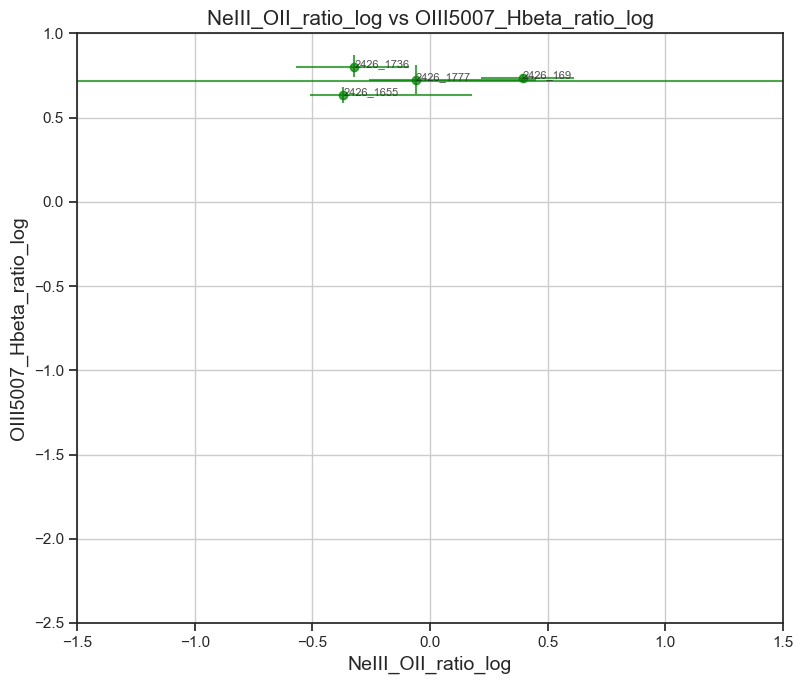

In [ ]:
# Optimized redshift bins for each survey (edit as needed for your science goals)
bpt_base_path = "bpt_plots"
os.makedirs(bpt_base_path, exist_ok=True)


# Line ratios for filtering and plotting
line_ratios_for_filter = ['NeIII_OII_SNR', 'OIII5007_Hbeta_SNR']
ratio_x = 'NeIII_OII_ratio'
err_x = 'NeIII_OII_ratio_err'
ratio_y = 'OIII5007_Hbeta_ratio'
err_y = 'OIII5007_Hbeta_ratio_err'

# Get unique surveys from your dataset
all_surveys = filtered_borg_survs['survey'].unique()

for survey in all_surveys:
    survey_lower = survey.lower()
    bins = survey_bins.get(survey_lower)
    if bins is not None:
        for zmin, zmax in bins:
            # 1️⃣ Extract dataframe for this survey and redshift bin
            df_subset = get_df(survey, 100, zmin, zmax)

            # 2️⃣ Filter for SNR > 2 for both ratios
            df_snr = filter_galaxy(df_subset, SNR_filter=2, line_ratios=line_ratios_for_filter)

            # 3️⃣ Generate BPT diagram if df_snr is not empty
            if not df_snr.empty:

                survey_plot_dir = os.path.join(bpt_base_path, survey)
                os.makedirs(survey_plot_dir, exist_ok = True)

                pickle_path = os.path.join(survey_plot_dir, f"{survey}_z_{zmin}_to_{zmax}.pkl")
                plot_filename = f"{survey}_z_{zmin}_to_{zmax}.png"
                plot_path = os.path.join(survey_plot_dir, plot_filename)
                fig = make_bpt(
                    df_snr,
                    ratio_x=ratio_x,
                    err_x=err_x,
                    ratio_y=ratio_y,
                    err_y=err_y,
                    title=f"{survey} z={zmin}-{zmax}",
                    x_label=r"[NeIII]/[OII]",
                    y_label=r"[OIII]/Hβ",
                    xlim=(-1.5, 1.5),
                    ylim=(-2.5, 1), save_pickle = True, pickle_filename = pickle_path, plot_filename = plot_path
                )
            else:
                print(f"No galaxies passed SNR filter in {survey} z={zmin}-{zmax}.")
    else:
        print(f"⚠️ No redshift bins defined for survey '{survey}' — skipping.")